<a href="https://colab.research.google.com/github/alexc6h6/Image-Classification-CNN/blob/master/transfer_learning(VGG16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning(VGG16)

Transfer learning is the improvement of learning in a new task through the transfer of model from a related task that has already been trained.


VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. 

The architecture depicted below is VGG16.



![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16.png)

In [2]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
import cv2
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from glob import glob
from google.colab.patches import cv2_imshow
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!ls '/content/drive/My Drive/natural_images'

print(len(os.listdir('/content/drive/My Drive/natural_images')))

airplane  car  cat  dog  flower  fruit	motorbike  person
8


In [0]:
#loading image data from folder to make array for training

data_folder_path = '/content/drive/My Drive/natural_images'

images = []
labels = []
for class_folder in os.listdir(data_folder_path):
  class_folder_path = os.path.join(data_folder_path, class_folder)
  for image_path in glob(os.path.join(class_folder_path, '*.jpg')):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (96,96))

    images.append(image)
    labels.append(class_folder)

images = np.array(images)
labels = np.array(labels)


In [9]:
print(images.shape)
print(labels.shape)


(6899, 96, 96, 3)
(6899,)


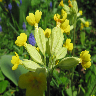

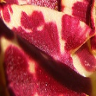

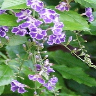

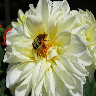

In [10]:
for image in images[1:5]:
  cv2_imshow(image)


In [0]:
#normalize the images
images = images/255.0

In [12]:
#transform labels in to one-hot code labels
le = LabelEncoder()
ohe = OneHotEncoder(categories = 'auto')

num_labels = le.fit_transform(labels)
ohe_labels = ohe.fit_transform(num_labels.reshape(-1, 1)).toarray()

print(ohe_labels.shape)

(6899, 8)


In [0]:
#split data into training set and validation set
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, ohe_labels, test_size = 0.1)

In [0]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              patience = 5,
                              verbose =1,
                              min_lr = 0.000001, 
                              factor = 0.033)

In [15]:
#transfer learning by VGG16
vgg_model = VGG16(include_top = False, weights = 'imagenet', input_shape = (96, 96, 3))

for layer in vgg_model.layers:
  layer.trainable = False

#the output of vgg16 connected with fully connected NN to classify the images
vgg_output = vgg_model.output
x = tf.keras.layers.Flatten()(vgg_output)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Dense(512, kernel_regularizer = regularizers.l2(0.1))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)

x = tf.keras.layers.Dense(256, kernel_regularizer = regularizers.l2(0.1))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)

output = tf.keras.layers.Dense(8, activation = 'softmax')(x)

model = Model(inputs = vgg_model.input, outputs = output)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['acc'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

In [16]:
epochs = 50
batch = 128

history = model.fit(x_train, y_train, 
                    epochs = epochs, 
                    batch_size = batch, 
                    verbose = 1,
                    callbacks = [reduce_lr], 
                    validation_data = (x_val, y_val))

Epoch 1/50
49/49 [==============================] - 14s 292ms/step - loss: 37.8814 - acc: 0.8790 - val_loss: 7.1683 - val_acc: 0.9435 - lr: 0.0010
Epoch 2/50
49/49 [==============================] - 12s 238ms/step - loss: 3.0205 - acc: 0.9372 - val_loss: 2.6500 - val_acc: 0.9058 - lr: 0.0010
Epoch 3/50
49/49 [==============================] - 12s 239ms/step - loss: 1.2744 - acc: 0.9341 - val_loss: 1.8062 - val_acc: 0.9203 - lr: 0.0010
Epoch 4/50
49/49 [==============================] - 12s 240ms/step - loss: 1.0655 - acc: 0.9377 - val_loss: 1.5340 - val_acc: 0.8986 - lr: 0.0010
Epoch 5/50
49/49 [==============================] - 12s 241ms/step - loss: 1.0627 - acc: 0.9369 - val_loss: 1.3103 - val_acc: 0.8942 - lr: 0.0010
Epoch 6/50
49/49 [==============================] - 12s 242ms/step - loss: 1.0667 - acc: 0.9327 - val_loss: 1.2326 - val_acc: 0.9333 - lr: 0.0010
Epoch 7/50
49/49 [==============================] - 12s 242ms/step - loss: 1.0953 - acc: 0.9333 - val_loss: 1.1013 - val_ac

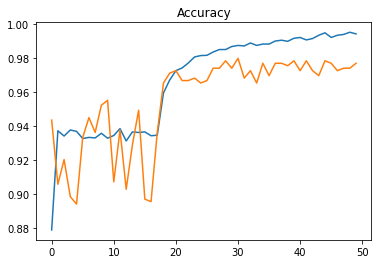

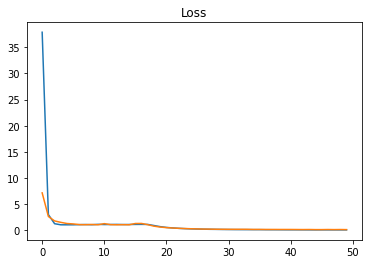

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.show()